# Holistic Determination of Optoelectronic Properties using High-Throughput Spectroscopy of Surface-Guided CsPbBr$_3$ Nanowires

Authors:
- _Stephen Church (stephen.church@manchester.ac.uk)_
- _Hoyeon Choi (hoyeon.choi@postgrad.manchester.ac.uk)_
- _Nawal Al-Amairi (nawal.alamairi@postgrad.manchester.ac.uk)_
- _Ruqaiya Al-Abri (ruqaiya.al-abri@postgrad.manchester.ac.uk)_
- _Ella Sanders (ella.sanders@weizmann.ac.il)_
- _Eitan Oksenberg (e.oksenberg@amolf.nl)_
- _Ernesto Joselevich (ernesto.joselevich@weizmann.ac.il)_
- _Patrick Parkinson (patrick.parkinson@manchester.ac.uk)_

This notebook shows how to manipulate and experiment with the dataset associated with [arxiv 2204.14065](https://arxiv.org/abs/2204.14065). The master dataset consists of a number of measurements over a large population to produce a spare multi-modal set.

## Dataset Format
The data is provided as a structured H5 file at [DOI:10.48420/19746019](https://dx.doi.org/10.48420/19746019), which provides correlated datasets of imagery, spectroscopy, and geometrical details. This notebook provides a basic method to explore this dataset and generate correlations associated with this research.

In [9]:
# Required to download the dataset
import urllib.request as url
import os   
import zipfile
import progressbar
# Required to import the dataset
import tables
# Required to process the dataset
import numpy as np
import scipy.signal as sig
# Required to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Useful progressbar for downloading dataset
class MyProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

# Download data
if not os.path.isfile('nanowire_data.h5'):
    print('Downloading dataset')
    url.urlretrieve('https://figshare.manchester.ac.uk/ndownloader/files/35083957','nanowire_data.h5.zip', MyProgressBar())
    with zipfile.ZipFile(f'nanowire_data.h5.zip', 'r') as zip_ref:
        zip_ref.extractall()
else:
    print('Dataset already downloaded')

100% (177654034 of 177654034) |##########| Elapsed Time: 0:00:06 Time:  0:00:06


In [11]:
# Open data
datafile_reference = tables.open_file('nanowire_data.h5',mode='r')
dataset = datafile_reference.root.nanowires
print(f'The dataset contains {dataset.geometry.length.shape[1]} structures')

The dataset contains 8342 structures


---
## Show the data

The dataset contains sets including:
- **pic** : images of the dataset
- **geometry** : Extracted geometrical information such as:
  - length
  - width
  - orientation (angle with respect to the imaging system)
  - position on substrate
- **spectral_(top,bottom)** spectral information under top or bottom excitation, including:
  - urbach_fitting: Output from the convoluted Urbach fit provided in the paper, including:
    - sigma
    - A
    - dE
    - peak
    - T
    - chi
    - E_0
    - bandgap
  - spectral_peak_energy : The peak position of the spectrum in energy units
  - spectral_FWHM_energy : The FWHM of the spectrum in energy units
  - integrated_peak : The integral of the PL data
  - spectra : Raw spectral data (corrected for blackbody emission)
- **TCSPC_(top,bottom)** Time resolved spectra for top and bottom excitation
  - TCSPC: The data itself
  - Fitting: The parameters extracted from fitting
    - tau2 : The long lifetime
    - t_0
    - A2 : Amplitude of the long component
    - A1 : Amplitude of the short component
    - resnorm
    - tau1 : The short component
    - int_ratio : Ratio of long and short components
- **power_dependant_TSCPC** The collection of power-depndant TCSPC measurements.
  - powers: The range of laser powers used for each experiment
  - slope_ts: The extracted gradient for surface-dependant results
  - slope_tv: The extracted gradient for volume results
  - thresh_tv: The threshold for volume defect saturation
  - tcspcs: The TCSPC data
  - thresh_ts: The threshold for surface defect saturation
---
### Filtering
Not every structure has every measurement associated with it. We can prepare a subset of the data that contains PL and TCSPC from both directions as "complete_ids", by looking for datasets that are not empty.

In [12]:
PL = sum(dataset.spectral_bottom.spectra,0)
TCSPC_t = sum(dataset.tcspc_top.TCSPC,0)
TCSPC_b = sum(dataset.tcspc_bottom.TCSPC,0)
complete_ids = np.where(PL & TCSPC_t & TCSPC_b)[0]
print(f'A total of {complete_ids.size} structures have both PL and both TCSPC directions.')

A total of 239 structures have both PL and both TCSPC directions.


We define a couple of helper functions for smoothing (s) and normalization (n), and extract the wavelength axis (wl) and time axis (xt) for the primary data sets.

In [13]:
## Helpers
s = lambda x:sig.medfilt(x,kernel_size=11)
n = lambda x:x/np.max(x)
wl = np.array(datafile_reference.root.info.spectrometer_wavelength).T
xt = np.array(datafile_reference.root.info.tcspc_axis)

### Selecting a dataset to visualise

The first "complete" wire is selected; the first ID which contains PL and both top and bottom excitation TCSPC. All of the datasets arising from this are collected.

Geometry:
	length : [16.23937134]
	orientation : [-35.91654929]
	position : [-0.16375  0.03245]
	width : [1.28608345]
	width_bottom : [1.28608345]


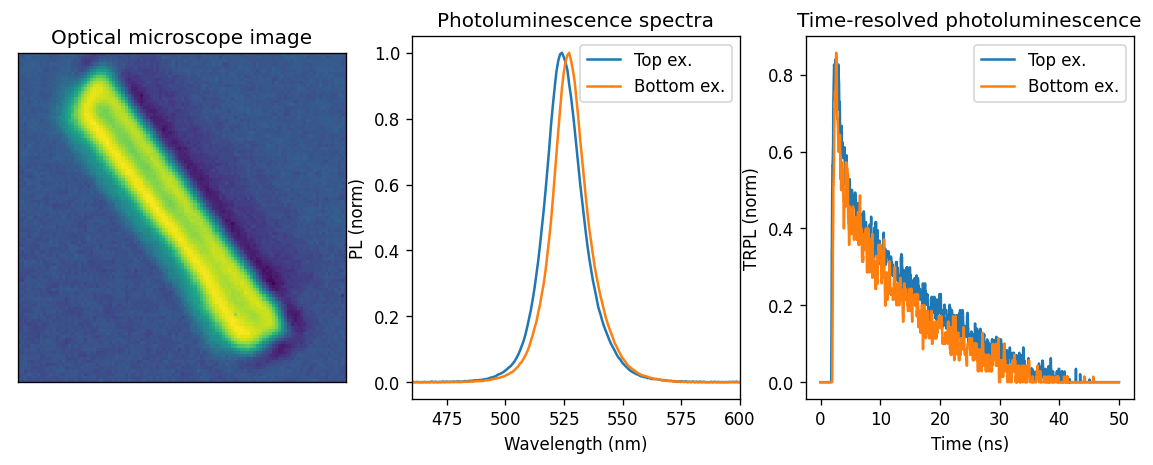

In [14]:
# Select one structure from the total set which have all 5 key measurements (Pic, 2x spectra, 2x TCSPC)
nanowire = complete_ids[1]

# Show all geometry parameters
print('Geometry:')
for k in dataset.geometry:
    print(f'\t{k.name} : {k[:,nanowire]}')

# Create a high-resolution figure
plt.figure(figsize=[12,4],dpi = 120)

# Show optical image
plt.subplot(131)
plt.imshow(dataset.pic[:,:,nanowire])
plt.xticks([])
plt.yticks([])
plt.title('Optical microscope image')

# Show photoluminescence spectra
plt.subplot(132)
plt.plot(wl,n(dataset.spectral_top.spectra[:,nanowire]),
         wl,n(dataset.spectral_bottom.spectra[:,nanowire]))
plt.xlim([460,600])
plt.xlabel('Wavelength (nm)')
plt.ylabel('PL (norm)')
plt.legend(['Top ex.','Bottom ex.'])
plt.title('Photoluminescence spectra')

# Show time-resolved photoluminescence spectra
plt.subplot(133)
plt.plot(xt,s(n(dataset.tcspc_top.TCSPC[:,nanowire])),
         xt,s(n(dataset.tcspc_bottom.TCSPC[:,nanowire])))
plt.xlabel('Time (ns)')
plt.ylabel('TRPL (norm)')
plt.title('Time-resolved photoluminescence')
plt.legend(['Top ex.','Bottom ex.']);

### Correlation of datasets
The power of this approach is also shown in collections of data across the population - for instance histograms or correlations. We show a length histogram here.

It is noted that this distribution appears bi-modal.

Cutting 981 of 8342 datasets where length data is missing or unavailable.


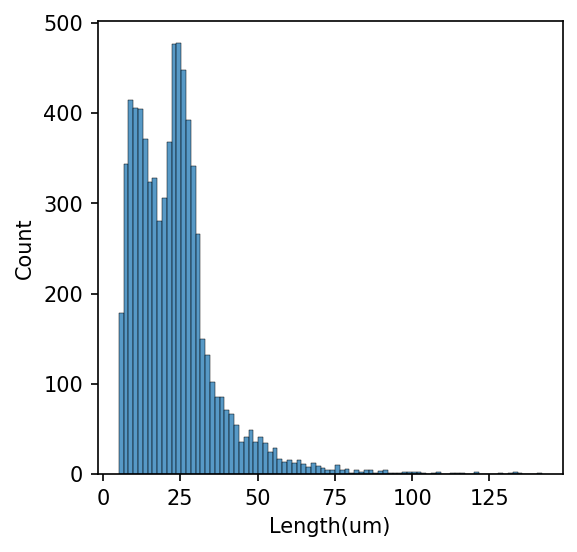

In [15]:
# Create a numpy array of lengths
l = np.double(dataset.geometry.length);

plt.figure(figsize=[4,4],dpi = 150)
# Create histogram, avoiding NaN values (possible where length calculation failed)
sns.histplot(l[~np.isnan(l)])
print(f'Cutting {np.sum(np.isnan(l))} of {l.size} datasets where length data is missing or unavailable.')
plt.xlabel('Length(um)');

We can also correlate between measurements, for instance photoluminescence peak and width. This is used in the paper to demonstrate the impact of strain, with thinner wires exhibiting greater strain and higher bandgap.

Filtering out 1540 of 8342 datapoints away from central peak to enhance visibility of trend. 6802 structure are used.


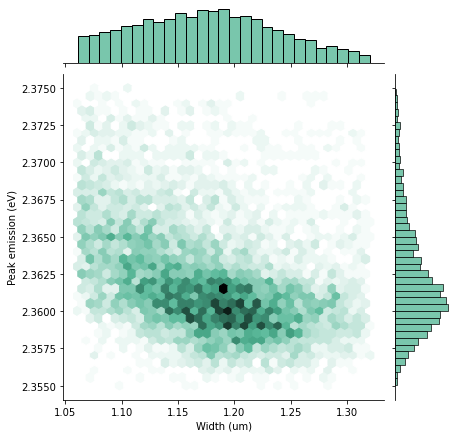

In [16]:
# Select region close to peak
m = np.where(np.array(dataset.geometry.width[0,:]>0) &
             np.array(dataset.geometry.width[0,:]<1.32) &
             np.array(dataset.spectral_top.urbach_fitting.peak[0,:]>2.355) & 
            np.array(dataset.spectral_top.urbach_fitting.peak[0,:]<2.375))
print(f'Filtering out {l.size-m[0].size} of {l.size} datapoints away from central peak to enhance visibility of trend. {m[0].size} structure are used.')
# Convert to a mask to apply to the dataset
m = list(m[0])

# Produce a 2D hexbin to visualise the scatter,
sns.jointplot(x=dataset.geometry.width[0,m], y=dataset.spectral_top.urbach_fitting.peak[0,m], kind="hex", color="#4CB391")
plt.xlabel('Width (um)')
plt.ylabel('Peak emission (eV)');